In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import backend,Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [3]:
datasetPath='..\kvasir-dataset'
categories=[
    'dyed-lifted-polyps', 
    'dyed-resection-margins',
    'esophagitis',
    'normal-cecum',
    'normal-pylorus',
    'normal-z-line',
    'polyps',
    'ulcerative-colitis'
]
EPOCHS = 25
Learing_Rate = 1e-3
Batch_Size = 128

In [43]:
def buildModel(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    if backend.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
    # Inception V3
    base_model = InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_shape=inputShape)
    base_model.trainable = False
#     pre_trained_model.load_weights(local_weights_file)


#     for layer in base_model.layers:
#         layer.trainable = False
    model.add(base_model.get_layer('mixed7'))
    model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128))
    model.add(Activation("relu"))
    # softmax classifier
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model

In [5]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

In [6]:
data = []
labels = []

print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(datasetPath)))
random.seed(42)
random.shuffle(imagePaths)

printProgressBar(0, len(imagePaths), prefix = 'Progress:', suffix = 'Complete', length = 50)
for i,imagePath in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (96, 96))
    image = img_to_array(image)
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    label = categories.index(label)
    labels.append(label)
    printProgressBar(i + 1, len(imagePaths), prefix = 'Progress:', suffix = 'Complete', length = 50)

print("[INFO] loading images completed...")

[INFO] loading images...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[INFO] loading images completed...


In [7]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

trainY = to_categorical(trainY, num_classes=8)
testY = to_categorical(testY, num_classes=8)

In [8]:
print ("number of training examples = " + str(trainX.shape[0]))
print ("number of test examples = " + str(testX.shape[0]))
print ("X_train shape: " + str(trainX.shape))
print ("Y_train shape: " + str(trainY.shape))
print ("X_test shape: " + str(testX.shape))
print ("Y_test shape: " + str(testY.shape))

number of training examples = 3000
number of test examples = 1000
X_train shape: (3000, 96, 96, 3)
Y_train shape: (3000, 8)
X_test shape: (1000, 96, 96, 3)
Y_test shape: (1000, 8)


In [9]:
generator = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [10]:
class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.99):
                    print("\n[INFO] Reached 99% accuracy so cancelling training!")
                    self.model.stop_training = True
# tb_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [44]:
print("[INFO] compiling model...")
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
model = buildModel(width=96, height=96, depth=3, classes=8)
# model.summary()

[INFO] compiling model...


In [45]:
opt = Adam(lr=Learing_Rate, decay=Learing_Rate / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [46]:
# print("[INFO] training network...")
callbacks=[myCallback()]
history = model.fit(
    x=generator.flow(trainX, trainY, batch_size=Batch_Size),
    validation_data=(testX, testY), 
    steps_per_epoch=len(trainX) // Batch_Size,
    epochs=EPOCHS, 
    verbose=1)
print("[INFO] training network completed...")

ValueError: A merge layer should be called on a list of inputs.

In [25]:
print("[INFO] saving model...")
model.save('Model_Inception.model', save_format="h5")
print("[INFO] model saved")

[INFO] saving model...
[INFO] model saved


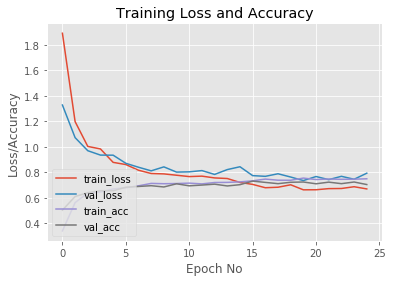

<Figure size 432x288 with 0 Axes>

In [26]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch No")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('plot_Inception.png')